In [1]:
import flopy as fp
import pyemu
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os, shutil, glob, sys
import json

# PEST setup
This notebook reads in the existing MF6 model built using modflow-setup with the script `../scripts/setup_model.py`. This notebook makes extensive use of the `PstFrom` functionality in `pyemu` to set up multipliers on parameters. There are a few custom parameterization steps as well.  

Observations are also defined, assigned initial values, and weights based on preliminary assumptions about error.

In [2]:
pyemu.__version__

'1.0.0+237.g133e84e9'

#### define locations and other global variables

In [3]:
sim_ws = '../neversink_mf6/' # folder containing the MODFLOW6 files
template_ws = '../run_data'  # folder to create and write the PEST setup to
noptmax0_dir = '../noptmax0_testing/' # folder in which to write noptmax=0 test run version of PST file

#### kill the `original` folder (a relic from the mfsetup process)

In [4]:
if os.path.exists(os.path.join(sim_ws,'original')):
    shutil.rmtree(os.path.join(sim_ws,'original'))

In [5]:
run_MF6 = True # option to run MF6 to generate output but not needed if already been run in sim_ws
cdir = os.getcwd()


# optionally run MF6 to generate model output
if run_MF6:
    os.chdir(sim_ws)
    os.system('mf6')
    os.chdir(cdir)

### create land surface observations we will need at the end
These will be used as inequality observations (less than) to enforce that heads should not exceed the model top. Option for spatial frequency is set below.

In [6]:
irch_file = f'{sim_ws}/irch.dat'    # file with the highest active layer identified
id3_file = f'{sim_ws}/idomain_003.dat' # deepest layer idomain - gives the maximum lateral footprint
top_file = f'{sim_ws}/top.dat'     # the model top

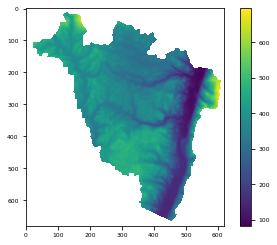

In [7]:
top = np.loadtxt(top_file)
top[top<-8000] = np.nan
plt.imshow(top)

plt.colorbar()

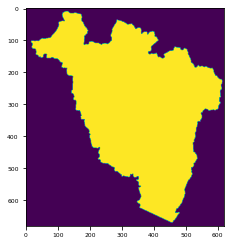

In [8]:
id3  = np.loadtxt(id3_file, dtype=int)
plt.imshow(id3)

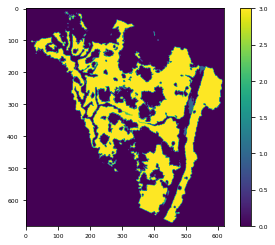

In [9]:
irch = np.loadtxt(irch_file, dtype=int) 
irch -= 1 # note that this is 1-based, not 0-based because it's a MF6 file
plt.imshow(irch)
plt.colorbar()

In [10]:
# set frequency for land surface observations lateralls, in model cells
lsobs_every_n_cells = 50 

In [11]:
# make a grid of cells spaced at the spacing suggested above
nrow, ncol = id3.shape
j = list(range(ncol))[0:ncol:lsobs_every_n_cells]
i = list(range(nrow))[0:nrow:lsobs_every_n_cells]
J,I = np.meshgrid(j,i)
points = list(zip(I.ravel(),J.ravel()))

In [12]:
# now keep only those that are in active cells (using ibound of layer4 as the basis) and drop a few others

In [13]:
keep_points = [(irch[i,j],i,j) for i,j in points if id3[i,j]==1]
drop_points = [(0, 150, 50),(3, 150, 100),(3, 100, 50)]
keep_points = [i for i in keep_points if i not in drop_points]

### make list of indices

In [14]:
with open(os.path.join(sim_ws,'land_surf_obs-indices.csv'), 'w') as ofp:
    ofp.write('k,i,j,obsname\n')
    [ofp.write('{0},{1},{2},land_surf_obs_{1}_{2}\n'.format(*i)) for i in keep_points]

### make an observations file

In [15]:
with open(os.path.join(sim_ws,'land_surf_obs-observations.csv'), 'w') as ofp:
    ofp.write('obsname,obsval\n')
    [ofp.write('land_surf_obs_{1}_{2},{3}\n'.format(*i, top[i[1],i[2]])) for i in keep_points]

# Start setting up the `PstFrom` object to create PEST inputs
### load up the simulation

In [16]:
sim = fp.mf6.MFSimulation.load(sim_ws=sim_ws)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package oc...
    loading package wel...
    loading package obs...
    loading package chd...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 176 based on size of stress_period_data
    loading package sfr...
  loading ims package neversink...


In [17]:
m = sim.get_model()

In [18]:
# manually create a spatial reference object from the grid.json metadata
# this file created by modflow-setup
grid_data = json.load(open(os.path.join(sim_ws,'neversink_grid.json')))
sr_model = pyemu.helpers.SpatialReference(delr=grid_data['delr'],
                                           delc=grid_data['delc'],
                                           rotation= grid_data['angrot'],
                                           epsg = grid_data['epsg'],
                                           xul = grid_data['xul'],
                                           yul = grid_data['yul'],
                                           units='meters',
                                           lenuni=grid_data['lenuni'])

In [19]:
# create the PstFrom object 
pf = pyemu.utils.PstFrom(original_d=sim_ws, new_d=template_ws,
                 remove_existing=True,
                 longnames=True, spatial_reference=sr_model,
                 zero_based=False)

2021-03-12 10:56:18.652312 starting: opening PstFrom.log for logging
2021-03-12 10:56:18.652312 starting PstFrom process
2021-03-12 10:56:18.689215 starting: setting up dirs
2021-03-12 10:56:18.690212 starting: copying original_d '..\neversink_mf6' to new_d '..\run_data'
2021-03-12 10:56:19.588383 finished: copying original_d '..\neversink_mf6' to new_d '..\run_data' took: 0:00:00.898171
2021-03-12 10:56:19.588383 finished: setting up dirs took: 0:00:00.899168


## we will parameterize....
- pilot points for k, k33, r
- zones for l, k33, r
- constant for R
- sfr conductance by reach
- well pumping 
- CHDs

## parameterize list-directed well and chd packages


In [20]:
list_tags = {'wel_':[.8,1.2], 'chd_':[.8,1.2]}

In [21]:
for tag,bnd in list_tags.items():
    lb,ub = bnd
    filename = os.path.basename(glob.glob(os.path.join(template_ws, '*{}*'.format(tag)))[0])
    pf.add_parameters(filenames=filename, par_type = 'grid',
                     upper_bound=ub, lower_bound=lb, par_name_base=tag,
                     index_cols=[0,1,2], use_cols=[3],pargp=tag[:-1],alt_inst_str='',
                     comment_char='#')

2021-03-12 10:56:19.724033 starting: adding grid type multiplier style parameters for file(s) ['wel_000.dat']
2021-03-12 10:56:19.725029 starting: loading list ..\run_data\wel_000.dat
2021-03-12 10:56:19.725029 starting: reading list ..\run_data\wel_000.dat
2021-03-12 10:56:19.732009 finished: reading list ..\run_data\wel_000.dat took: 0:00:00.006980
2021-03-12 10:56:19.732009 loaded list '..\run_data\wel_000.dat' of shape (34, 5)
2021-03-12 10:56:19.739988 finished: loading list ..\run_data\wel_000.dat took: 0:00:00.014959
2021-03-12 10:56:19.739988 starting: writing list-based template file '..\run_data\wel__0_grid.csv.tpl'
2021-03-12 10:56:19.777263 finished: writing list-based template file '..\run_data\wel__0_grid.csv.tpl' took: 0:00:00.037275
2021-03-12 10:56:19.808515 finished: adding grid type multiplier style parameters for file(s) ['wel_000.dat'] took: 0:00:00.084482
2021-03-12 10:56:19.808515 starting: adding grid type multiplier style parameters for file(s) ['chd_000.dat']


## now set up pilot points

In [22]:
k_ub = 152 # ultimate upper bound on K
# set up pilot points
pp_tags = {'k':[.01,10.,k_ub], 'k33':[.01,10.,k_ub/10]}

### we will use idomain to define zones for pilot points as going in active areas of each layer.

In [23]:
idm = m.dis.idomain.array

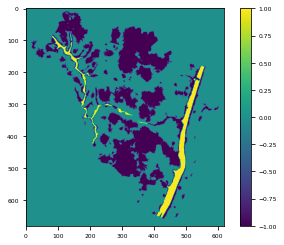

In [24]:
plt.imshow(idm[2])
plt.colorbar()

In [25]:
idm[idm==-1]=0 # make pass through cells (e.g. idomain==-1) the same as inactive (e.g. idomain == 0)

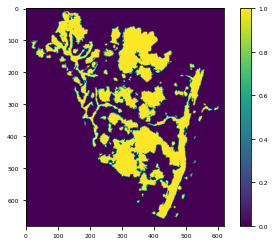

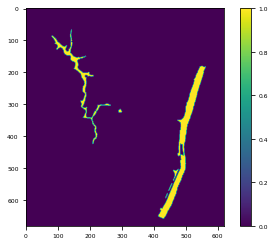

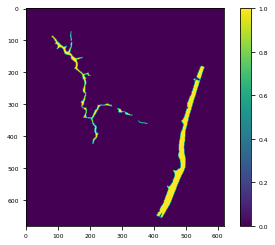

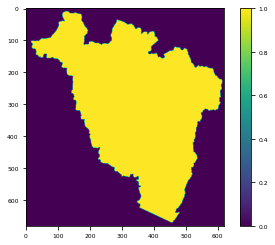

In [26]:
for i in range(4):
    plt.figure()
    plt.imshow(idm[i])
    plt.colorbar()

#### before setting up K, need to edit the zone files to only have nonzero values in active cells

In [27]:
kzonefile = '../processed_data/padded_L{}_K_Zone_50mGrid.dat'
zonearrs = {}
for i in range(m.dis.nlay.data):
    kz = np.loadtxt(kzonefile.format(i)).astype(int)
    kz[idm[i] != 1] = 0 
    zonearrs[i] = kz


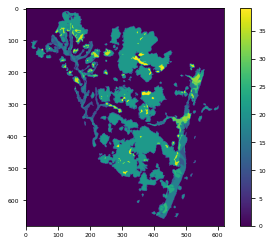

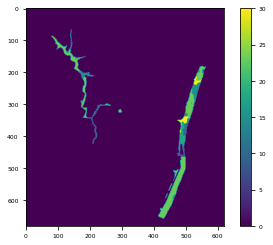

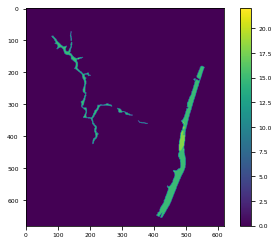

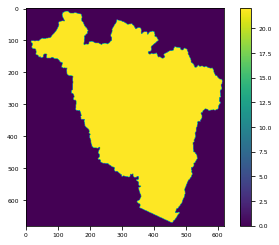

In [28]:
for i in range(4):
    plt.figure()
    plt.imshow(zonearrs[i])
    plt.colorbar()

In [29]:
# quick take a look at unique zones present in each layer
[np.unique(kz) for _,kz in zonearrs.items()]

[array([ 0, 11, 12, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
        31, 32, 33, 34, 35, 36, 37, 38, 39]),
 array([ 0, 11, 15, 17, 18, 20, 21, 22, 23, 24, 28, 30]),
 array([ 0, 15, 18, 20, 21, 22]),
 array([ 0, 22])]

In [30]:
## set up for K
for tag,bnd in pp_tags.items():
    lb, ub, ultub = bnd
    if tag == 'k':
        arrfiles = sorted([f for f in os.listdir(template_ws) if f.startswith(tag) & ('k33' not in f)])
    else:
        arrfiles = sorted([f for f in os.listdir(template_ws) if f.startswith(tag)])
    
    for arr_file in arrfiles:        
        currlay = int(re.findall('\d+',arr_file.replace('k33',''))[-1])
        
        # pilot points
        # set pilot point spacing: NB every 5 cells in the smaller-zone layers, and every 20 cells in others
        if currlay in [1,2]:
            pp_space = 5           
        else: 
            pp_space = 20
        v = pyemu.utils.geostats.ExpVario(a=sr_model.delr[0]*3*pp_space,contribution=1.0)
        gs = pyemu.utils.geostats.GeoStruct(variograms=v,nugget=0.0, transform='log')

        print('pps for layer {} --- filename: {}: idomain_sum: {}'.format(currlay, arr_file, idm[currlay].sum()))
        pf.add_parameters(filenames=arr_file, par_type='pilotpoints', pp_space=pp_space,
                         upper_bound=ub, lower_bound=lb, geostruct=gs,
                         par_name_base='{}_pp'.format(tag),alt_inst_str='',
                         zone_array=idm[currlay], pargp='pp_{}'.format(tag),
                         ult_ubound=ultub)
        # zones
        print('zones for layer {} --- filename: {}: idomain_sum: {}'.format(currlay, arr_file, idm[currlay].sum()))
        pf.add_parameters(filenames=arr_file, par_type='zone',alt_inst_str='',
                         zone_array = zonearrs[currlay],lower_bound=lb,upper_bound=ub,
                         pargp='zn_{}'.format(tag), par_name_base='{}_{}'.format(tag,currlay),
                          ult_ubound=ultub)
        

pps for layer 0 --- filename: k0.dat: idomain_sum: 85051
2021-03-12 10:56:24.591059 starting: adding pilotpoints type multiplier style parameters for file(s) ['k0.dat']
2021-03-12 10:56:24.591059 starting: loading array ..\run_data\k0.dat
2021-03-12 10:56:24.906922 finished: loading array ..\run_data\k0.dat took: 0:00:00.315863
2021-03-12 10:56:24.906922 loaded array '..\neversink_mf6\k0.dat' of shape (680, 619)
2021-03-12 10:56:25.272039 starting: writing array-based template file '..\run_data\k_pp_0_pilotpoints.csv.tpl'
2021-03-12 10:56:25.272039 starting: setting up pilot point parameters
2021-03-12 10:56:25.272039 No spatial reference (containing cell spacing) passed.
2021-03-12 10:56:25.272039 OK - using spatial reference in parent object.
2021-03-12 10:56:25.804533 202 pilot point parameters created
2021-03-12 10:56:25.804533 pilot point 'pargp':k_pp_:0
2021-03-12 10:56:25.804533 finished: setting up pilot point parameters took: 0:00:00.532494
2021-03-12 10:56:25.873546 starting:

In [31]:
# recharge as special case because no idomain for R
rtags= {'rch':[0.8,1.2, np.max(m.rch.recharge.array)*1.2]}

In [32]:
for tag,bnd in rtags.items():
    lb, ub, ultub = bnd
    if tag == 'k':
        arrfiles = sorted([f for f in os.listdir(template_ws) if f.startswith(tag) & ('k33' not in f)])
    else:
        arrfiles = sorted([f for f in os.listdir(template_ws) if f.startswith(tag)])
    
    for arr_file in arrfiles:
        # pilot points
        pf.add_parameters(filenames=arr_file, par_type='pilotpoints', pp_space=pp_space,
                         upper_bound=ub, lower_bound=lb, geostruct=gs,
                         par_name_base='{}_pp'.format(tag),
                          zone_array=idm[3],alt_inst_str='',
                         pargp='pp_{}'.format(tag),
                          ult_ubound=ultub)
        # constant
        pf.add_parameters(filenames=arr_file, par_type='constant',
                 upper_bound=ub-0.1, lower_bound=lb+0.1, 
                 par_name_base='{}_const'.format(tag),
                 zone_array=idm[3],alt_inst_str='',
                 pargp='pp_{}'.format(tag),
                           ult_ubound=ultub)


2021-03-12 11:25:41.009797 starting: adding pilotpoints type multiplier style parameters for file(s) ['rch_000.dat']
2021-03-12 11:25:41.010792 starting: loading array ..\run_data\rch_000.dat
2021-03-12 11:25:41.592292 finished: loading array ..\run_data\rch_000.dat took: 0:00:00.581500
2021-03-12 11:25:41.592292 loaded array '..\neversink_mf6\rch_000.dat' of shape (680, 619)
2021-03-12 11:25:42.207006 starting: writing array-based template file '..\run_data\rch_pp_0_pilotpoints.csv.tpl'
2021-03-12 11:25:42.208006 starting: setting up pilot point parameters
2021-03-12 11:25:42.208006 No spatial reference (containing cell spacing) passed.
2021-03-12 11:25:42.208006 OK - using spatial reference in parent object.
2021-03-12 11:25:44.097143 470 pilot point parameters created
2021-03-12 11:25:44.097143 pilot point 'pargp':rch_pp_:0
2021-03-12 11:25:44.097143 finished: setting up pilot point parameters took: 0:00:01.889137
2021-03-12 11:25:44.308386 starting: writing array-based template fil

## the `build_pst` method compiles all the parameters we've added and makes a `Pst` object

In [33]:
pst = pf.build_pst('tmp.pst')

noptmax:0, npar_adj:4172, nnz_obs:0


### Make a TPL file for SFR and add it to the `pst` object

In [34]:
sfrfilename = 'neversink_packagedata.dat'

print('working on {}'.format(sfrfilename))
# read in and strip and split the input lines
insfr = [line.strip().split() for line in open(os.path.join(template_ws,sfrfilename), 'r').readlines() if '#' not in line]
headerlines = [line.strip() for line in open(os.path.join(template_ws,sfrfilename), 'r').readlines() if '#' in line]

# set up the template line strings by segment
tpl_char = ['~ sfrk_{} ~'.format(line[-1]) for line in insfr]

# stick the tpl text in the K column. NB -> gotta count from the end because of 
# the possibility of NONE or i,j,k as indexing
for line,tpl in zip(insfr,tpl_char):
    line[-6] = tpl

# revert back to a space delimited file
insfr = [' '.join(line) for line in insfr]

# write out the TPL file
with open(os.path.join(template_ws,'{}.tpl'.format(sfrfilename)), 'w') as ofp:
    ofp.write('ptf ~\n')
    [ofp.write('{}\n'.format(line)) for line in headerlines]
    [ofp.write('{}\n'.format(line)) for line in insfr]

working on neversink_packagedata.dat


In [35]:
pst.add_parameters(os.path.join(template_ws,'{}.tpl'.format(sfrfilename)),  pst_path='.')

error trying to read input file with tpl file:different values 1.7662957:1.0 for par sfrk_700039914 on in line 15
915 pars added from template file .\neversink_packagedata.dat.tpl


,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
sfrk_700011363,sfrk_700011363,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
sfrk_200065864,sfrk_200065864,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
sfrk_700049673,sfrk_700049673,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
sfrk_200017209,sfrk_200017209,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
sfrk_200036649,sfrk_200036649,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
sfrk_200096410,sfrk_200096410,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
sfrk_700039911,sfrk_700039911,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
sfrk_700040003,sfrk_700040003,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
sfrk_200163977,sfrk_200163977,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1


In [36]:
parval1 = pyemu.pst_utils.try_read_input_file_with_tpl(os.path.join(template_ws,'{}.tpl'.format(sfrfilename)),
                                                 os.path.join(template_ws,sfrfilename))

error trying to read input file with tpl file:different values 1.7662957:1.0 for par sfrk_700039914 on in line 15


In [37]:
pst.parameter_data.loc[pst.parameter_data.parnme.str.startswith('sfr'),'pargp'] = 'sfrk'

In [38]:
pst.parameter_data.loc[pst.parameter_data.parnme == 'sfrk_700039914']

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,,usecol,idx0,idx1,idx2,i,j,zone
sfrk_700039914,sfrk_700039914,log,factor,1.0,1.100000e-10,1.100000e+10,sfrk,1.0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Add in the observations

## Assign meaningful observation values and prepare to run `noptmax=0` test run prior to reweighting

In [39]:
update_forward_run=True
run_local=True
update_all_obs = True

### if `update_all_obs` is True, run the get_observations.py script to get a new INS file and reset all observations in the PEST object

In [40]:
if update_all_obs is True:
    shutil.copy2('../scripts/get_observations.py',os.path.join(template_ws,'get_observations.py'))
    shutil.copy2('../scripts/get_observations.py',os.path.join(sim_ws,'get_observations.py'))
    
    os.system('python {} {} True'.format(os.path.join(sim_ws,'get_observations.py'), sim_ws))
    [shutil.copy2(cf, os.path.join(template_ws, os.path.basename(cf))) 
        for cf in glob.glob(os.path.join(sim_ws, '*.ins'))]
    [shutil.copy2(cf, os.path.join(template_ws, os.path.basename(cf))) 
        for cf in glob.glob(os.path.join(sim_ws, 'land_*.csv'))]
    
    pst.observation_data.loc[:,:] = np.nan
    pst.observation_data.dropna(inplace=True)
    pst.add_observations(os.path.join(template_ws,'obs_mf6.dat.ins'), pst_path='.')

error processing instruction/output file pair: output file '../run_data\.\obs_mf6.dat' not found
526 obs added from instruction file ../run_data\.\obs_mf6.dat.ins


###  set the observation groups

In [41]:
obs = pst.observation_data

In [42]:
obs.obgnme = 'head'

In [43]:
obs.loc[obs.index.str.startswith('q_'), 'obgnme'] = 'flux'

In [44]:
obs.loc[obs.index.str.startswith('perc'), 'obgnme'] = 'budget'
obs.loc[obs.index.str.startswith('land'), 'obgnme'] = 'land_surface'

### Set observation values


In [45]:
set_obs = True

In [46]:
if set_obs:
    # read in sfr; make sfr obsnme/obsval dict to map to pst observation_data
    sfr_df = pd.read_csv('../processed_data/NWIS_DV_STREAMSTATS_SITES.csv')
    sfr_df['obsnme'] = 'q_' + sfr_df['site_id'].astype(str)
    sfr_df['obsval'] = (sfr_df['Mean_Annual_Flow_cfs'] * sfr_df['Average_BFI_value']) * 2446.5755455 # convert from cfs to m^3/day
    sfr_df[['obsnme', 'obsval']]
    sfr_dict = pd.Series(sfr_df['obsval'].values,index=sfr_df['obsnme']).to_dict()
    
    # read in nwis heads; make nwis head obsnme/obsval dict
    nwis_gw_df = pd.read_csv('../processed_data/NWIS_GW_DV_data.csv')
    nwis_gw_df['obsnme'] = 'h_' + nwis_gw_df['site_no'].astype(str)
    nwis_gw_df['obsval'] = nwis_gw_df['gw_elev_m']
    nwis_gw_dict = pd.Series(nwis_gw_df['obsval'].values,index=nwis_gw_df['obsnme']).to_dict()
    
    # read in DEC heads; make DEC heads obsnme/obsval dict
    DEC_gw_df = pd.read_csv('../processed_data/NY_DEC_GW_sites.csv')
    DEC_gw_df['obsnme'] = ('h_' + DEC_gw_df['WellNO'].astype(str)).str.lower()
    DEC_gw_df['obsval'] = DEC_gw_df['gw_elev_m']
    DEC_gw_dict = pd.Series(DEC_gw_df['obsval'].values,index=DEC_gw_df['obsnme']).to_dict()
    
    # map SFR values to observation_data
    obs.loc[obs.obsnme.isin(sfr_dict.keys()), 'obsval'] = obs.obsnme.map(sfr_dict)
    
    # map nwis heads to observation_data
    obs.loc[obs.obsnme.isin(nwis_gw_dict.keys()), 'obsval'] = obs.obsnme.map(nwis_gw_dict)
    
    # map DEC heads to SRF observation_data
    obs.loc[obs.obsnme.isin(DEC_gw_dict.keys()), 'obsval'] = obs.obsnme.map(DEC_gw_dict)
    
    # set up percent discrepancy as dummy value
    obs.loc[obs.obgnme=='budget', 'obsval'] = -99999
    
    # get the land surface obs
    lsobs_df = pd.read_csv('../neversink_mf6/land_surf_obs-observations.csv', index_col=0)
    
    obs.loc[obs.obgnme=='land_surface', 'obsval'] = lsobs_df.obsval

### first cut at weights

In [47]:
obs.loc[obs.obsnme=='q_1436500', 'weight'] = 3.33/obs.loc[obs.obsnme=='q_1436500'].obsval
obs.loc[obs.obsnme=='q_1366650', 'weight'] = 10/obs.loc[obs.obsnme=='q_1366650'].obsval


In [48]:
obs.loc[obs.obgnme=='head', 'weight'] = 1/5
obs.loc[obs.obgnme=='land_surface', 'weight'] = 1/10

In [49]:
obs.loc[obs.obgnme=='budget', 'weight'] = 0.0

## update some parameter bounds

In [50]:
pars = pst.parameter_data

### K-zones set to not get too crazy high

In [51]:
#  read in k value lookup table to df

#  original table

k_df_original = pd.read_excel(
    '../processed_data/Rondout_Neversink_GeologyLookupTable.xlsx',
    sheet_name='Sheet2'
)
k_df_original.index = k_df_original.Lookup_Code

k_df = pd.read_excel(
    '../processed_data/Rondout_Neversink_GeologyLookupTable_jhw.xlsx',
    sheet_name='Sheet2'
)

k_df.index = k_df.Lookup_Code

print('Using mean K value')
k_df['Kh_ft_d_mean'] = (k_df['Kh_ft_d_lower'] + k_df['Kh_ft_d_upper']) / 2
k_df['Kh_m_d'] = k_df['Kh_ft_d_mean'] * 0.3048
    
k_df['Kh_m_d_lower'] = k_df['Kh_ft_d_lower'] * .3048
k_df['Kh_m_d_upper'] = k_df['Kh_ft_d_upper'] * .3048

k_df['K_upper_mult'] = k_df['Kh_m_d_upper'] / k_df['Kh_m_d']
k_df['K_lower_mult'] = k_df['Kh_m_d_lower'] / k_df['Kh_m_d']


k_df

Using mean K value


C:\ProgramData\Anaconda3\envs\NDST\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\ProgramData\Anaconda3\envs\NDST\lib\site-packages\xlrd\xlsx.py:312: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\ProgramData\Anaconda3\envs\NDST\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\ProgramData\Anaconda3\envs\NDST\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' o

,Geology_Type,Lookup_Code,Kh_ft_d_lower,Kh_ft_d_upper,Kh_ft_d_mean,Kh_m_d,Kh_m_d_lower,Kh_m_d_upper,K_upper_mult,K_lower_mult
Lookup_Code,,,,,,,,,,
11,Outwash,11,150.00,250.0,200.000,60.960000,45.720000,76.20000,1.250000,0.750000
12,Peat & outwash,12,150.00,250.0,200.000,60.960000,45.720000,76.20000,1.250000,0.750000
13,Water & outwash,13,150.00,250.0,200.000,60.960000,45.720000,76.20000,1.250000,0.750000
14,Basal Coarse,14,50.00,100.0,75.000,22.860000,15.240000,30.48000,1.333333,0.666667
15,Kame,15,50.00,100.0,75.000,22.860000,15.240000,30.48000,1.333333,0.666667
16,Alluvial fan,16,25.00,75.0,50.000,15.240000,7.620000,22.86000,1.500000,0.500000
17,Alluvium & outwash,17,100.00,200.0,150.000,45.720000,30.480000,60.96000,1.333333,0.666667
18,Kame moraine,18,10.00,50.0,30.000,9.144000,3.048000,15.24000,1.666667,0.333333
19,Till moraine,19,1.00,10.0,5.500,1.676400,0.304800,3.04800,1.818182,0.181818


In [52]:
k_mult_zones = [int(i.split(':')[-1]) for i in pars.loc[pars.parnme.str.startswith('multiplier_k')].index]
np.unique(k_mult_zones)

array([11, 12, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
       32, 33, 34, 35, 36, 37, 38, 39])

In [53]:
upper_mults = [k_df.loc[i].K_upper_mult for i in k_mult_zones]
lower_mults = [k_df.loc[i].K_lower_mult for i in k_mult_zones]

In [54]:
pars.loc[pars.parnme.str.startswith('multiplier_k'), 'parlbnd'] = lower_mults
pars.loc[pars.parnme.str.startswith('multiplier_k'), 'parubnd'] = upper_mults


### pilot points set to mean upper and lower bounds diffs

In [55]:
mean_lower = k_df.K_lower_mult.mean()
mean_upper = k_df.K_upper_mult.mean()
mean_lower,mean_upper

(0.4327586206896552, 1.5672413793103452)

In [56]:
pars.loc[pars.pargp.str.startswith('k'), 'parlbnd'] = mean_lower + 0.01
pars.loc[pars.pargp.str.startswith('k'), 'parubnd'] = mean_upper - 0.01
pars.loc[pars.pargp.str.startswith('sfrk'), 'parlbnd'] = 0.1
pars.loc[pars.pargp.str.startswith('sfrk'), 'parubnd'] = 10.0

### Set CHD parameters to 'fixed'. They will not be estimated, but are present to evaluate in global sensitivity analysis which means we will free them only for that purpose

In [57]:
pars.loc[pars.pargp=='chd', 'partrans'] = 'fixed'

#### `pyemu` can write out a summary file with summary of the parameterization

In [74]:
rm_dir = '../report_materials'

if not os.path.exists(rm_dir):
    os.makedirs(rm_dir)

In [75]:
parsum = pst.write_par_summary_table('../report_materials/initial_parsum.xlsx', report_in_linear_space=True)
parsum

,type,transform,count,initial value,lower bound,upper bound
chd,chd,fixed,176,1,0.8,1.2
k33_pp_:0,k33_pp_:0,log,202,1,0.442759,1.55724
k33_pp_:1,k33_pp_:1,log,560,1,0.442759,1.55724
k33_pp_:2,k33_pp_:2,log,473,1,0.442759,1.55724
k33_pp_:3,k33_pp_:3,log,470,1,0.442759,1.55724
k_pp_:0,k_pp_:0,log,202,1,0.442759,1.55724
k_pp_:1,k_pp_:1,log,560,1,0.442759,1.55724
k_pp_:2,k_pp_:2,log,473,1,0.442759,1.55724
k_pp_:3,k_pp_:3,log,470,1,0.442759,1.55724
pp_rch__multiplier,pp_rch__multiplier,log,1,1,0.9,1.1


## update the forward run to run

In [59]:
# note there are ways to do this within PstFrom but we were unaware of that when we set this up
# note also we are putting the model run and postprocessing lines just above if __name__ == "__main__" line
frunlines = open(os.path.join(template_ws, 'forward_run.py'), 'r').readlines()
if update_forward_run is True and './mf6' not in ' '.join([i.strip() for i in frunlines]):
    print('updating forward_run.py')
    with open(os.path.join(template_ws, 'forward_run.py'), 'w') as ofp:
        for line in frunlines:
            if '__main__' in line:
                ofp.write("    os.system('./mf6')\n")
                ofp.write("    os.system('python get_observations.py . false')\n")
                ofp.write('{}\n'.format(line)) 
            else:
                ofp.write(line)          


updating forward_run.py


### set noptmax = 0 and a couple ++ options and write out PST file

In [60]:
pst.pestpp_options["ies_num_reals"] = 500  
pst.pestpp_options["ies_bad_phi_sigma"] = 2
pst.pestpp_options["overdue_giveup_fac"] = 4
pst.pestpp_options["ies_save_rescov"] = True
pst.pestpp_options["ies_no_noise"] = True
pst.pestpp_options["ies_drop_conflicts"] = True
pst.pestpp_options["ies_pdc_sigma_distance"] = 2.0
pst.control_data.noptmax = 0

### write out the PST file

In [61]:
pst.write(os.path.join(template_ws,'prior_mc.pst'))

noptmax:0, npar_adj:4911, nnz_obs:525


# copy over the entire pest directory to a separate folder identified by the `noptmax0_dir` variable. This is to keep the `emplate_ws` clean and allow for various testing to take place int he `noptmax0_dir` location

In [62]:
if os.path.exists(noptmax0_dir):
    shutil.rmtree(noptmax0_dir)
shutil.copytree(template_ws, noptmax0_dir)

'../noptmax0_testing/'

In [63]:
pst.write_obs_summary_table('../report_materials/obs_initial.xlsx')

could not export ../report_materials/obs_initial.xlsx in Excel format. Try installing xlrd


,group,value,non-zero weight,zero weight,weight,standard deviation,percent error
budget,budget,-99999,0,1,0,NA,NA
flux,flux,124046 to 190290,2,0,1.74996E-05 to 8.06151E-05,12404.6 to 57144.1,10 to 30.03
head,head,59.3328 to 655.145,448,0,0.2,5,0.76319 to 8.42705
land_surface,land_surface,88.72 to 673.96,75,0,0.1,10,1.48377 to 11.2714


### If running on Windows, remove backslashes from `mult2model_info.csv` for running on linux cluster

In [65]:
if sys.platform == 'win32':
    f = open(os.path.join(template_ws, 'mult2model_info.csv'), "r")
    lines = f.readlines()
    f.close()

    output_lines = []
    for line in lines:
        output_lines.append(line.replace('\\', "/"))

    f = open(os.path.join(template_ws, 'mult2model_info.csv'), "w")
    f.write(''.join(output_lines))
    f.close()

### and the pest file

In [66]:
if sys.platform == 'win32':
    f = open(os.path.join(template_ws, 'prior_mc.pst'), "r")
    lines = f.readlines()
    f.close()

    output_lines = []
    for line in lines:
        output_lines.append(line.replace('\\', "/"))

    f = open(os.path.join(template_ws, 'prior_mc.pst'), "w")
    f.write(''.join(output_lines))
    f.close()

### and update the forward run command

In [73]:
if sys.platform == 'win32':
    f = open(os.path.join(template_ws, 'forward_run.py'), "r")
    lines = f.readlines()
    f.close()

    output_lines = []
    for line in lines:
        output_lines.append(line.replace('./mf6', "mf6"))

    # fix in run_dir 
    f = open(os.path.join(template_ws, 'forward_run.py'), "w")
    f.write(''.join(output_lines))
    f.close()
    
    # fix in noptmax_0_testing
    f = open(os.path.join(noptmax0_dir, 'forward_run.py'), "w")
    f.write(''.join(output_lines))
    f.close()